In [407]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import tensorflow as tf


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [74]:
world_population = pd.read_csv('./WorldPopulation/API_EN.POP.DNST_DS2_en_csv_v2_887474.csv')

In [322]:
world_population.loc[world_population['Country Name'].str.contains('Korea')]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
124,"Korea, Rep.",KOR,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,267.112513,274.860357,282.622299,290.111497,297.581111,...,509.815967,513.804280,515.875583,517.612291,520.852499,523.525548,525.656279,527.918011,529.652104,NaN
191,"Korea, Dem. People’s Rep.",PRK,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,96.882277,98.594070,100.203206,102.004975,104.206669,...,203.877053,204.911428,205.968042,207.038053,208.103579,209.150677,210.179752,211.194959,212.190175,NaN


In [518]:
test = pd.merge(train_df, world_population[['Country Name', '2018']], how='left', left_on='Country/Region', right_on='Country Name')

In [528]:
test[test['Country Name'].isna()]['Country/Region'].value_counts()

US                                  3306
Congo (Kinshasa)                      57
Venezuela                             57
Saint Vincent and the Grenadines      57
Jersey                                57
Brunei                                57
Guadeloupe                            57
The Bahamas                           57
Cruise Ship                           57
Reunion                               57
Egypt                                 57
Korea, South                          57
Martinique                            57
Russia                                57
French Guiana                         57
Congo (Brazzaville)                   57
Republic of the Congo                 57
Mayotte                               57
Holy See                              57
Kyrgyzstan                            57
The Gambia                            57
Iran                                  57
Czechia                               57
Taiwan*                               57
Saint Lucia     

In [494]:
train_df = pd.read_csv("covid19-global-forecasting-week-1/train.csv")
test_df = pd.read_csv("covid19-global-forecasting-week-1/test.csv")

In [514]:
test_df.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


In [437]:
data_world = train_df.groupby(['Country/Region', 'Date'])[['ConfirmedCases', 'Fatalities']].sum()

In [438]:
data_world['Lockdown'] = 0

In [439]:
data_world.loc[(data_world.index.get_level_values('Country/Region')=='China') 
           & (data_world.index.get_level_values('Date')>='2020-01-24'), 'Lockdown'] = 1

data_world.loc[(data_world.index.get_level_values('Country/Region')=='Italy') 
           & (data_world.index.get_level_values('Date')>='2020-03-09'), 'Lockdown'] = 1

data_world.loc[(data_world.index.get_level_values('Country/Region')=='Iran') 
           & (data_world.index.get_level_values('Date')>='2020-03-13'), 'Lockdown'] = 1

In [ ]:
# # China data
# cn_data = train_df[train_df['Country/Region']=='China'][['Date', 'ConfirmedCases', 'Fatalities']].groupby('Date').sum().reset_index()
# cn_data['Lockdown'] = 0
# cn_data.iloc[2:, -1] = 1

In [ ]:
# # Three countries data
# data_sample = data_world[data_world.index.get_level_values('Country/Region').isin(['China', 'Italy', 'Iran'])]
# data_confirm = data_sample[['ConfirmedCases', 'Lockdown']].droplevel('Country/Region')
# data_confirm = (data_confirm - data_confirm.mean(axis=0)) / data_confirm.std(axis=0)

In [ ]:
# def prepare_confirmed_data(subset, num_cols):
#     mean = subset[num_cols].mean()
#     subset[num_cols] = (subset[num_cols] - subset[num_cols].mean()) / subset[num_cols].std()
#     return subset

In [441]:
data_min = data_world.min(axis=0)
data_max = data_world.max(axis=0)
data_world = (data_world - data_min) / (data_max - data_min)

In [442]:
data_world.tail()

ConfirmedCases  Fatalities  Lockdown
Country/Region Date                                            
Zambia         2020-03-14        0.000000         0.0       0.0
               2020-03-15        0.000000         0.0       0.0
               2020-03-16        0.000000         0.0       0.0
               2020-03-17        0.000000         0.0       0.0
               2020-03-18        0.000025         0.0       0.0

In [443]:
def multivariate_data(dataset, target, 
                      start_index, end_index, 
                      history_size, target_size, 
                      step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return data, labels

In [444]:
data_world.head()

ConfirmedCases  Fatalities  Lockdown
Country/Region Date                                            
Afghanistan    2020-01-22             0.0         0.0       0.0
               2020-01-23             0.0         0.0       0.0
               2020-01-24             0.0         0.0       0.0
               2020-01-25             0.0         0.0       0.0
               2020-01-26             0.0         0.0       0.0

In [504]:
## iterate through each country and construct time series data
random.seed(1)
data_world.index.get_level_values('Country/Region').unique()
num_cols= ['ConfirmedCases', 'Fatalities']
history_data = 14
STEP = 1
X_train = []
y_train = []
X_test = []
y_test = []
for country in data_world.index.get_level_values('Country/Region').unique():
    country_data = data_world.loc[country].values

    data, label = multivariate_data(country_data, country_data[:,0],
                                    0, None, history_data, 7, STEP)
    
    idx_test = random.sample(range(len(data)), int(len(data)*0.2))
    idx_train = [idx for idx in range(len(data)) if idx not in idx_test]
    
    X_test.extend([data[idx] for idx in idx_test])
    y_test.extend([label[idx] for idx in idx_test])
    X_train.extend([data[idx] for idx in idx_train])
    y_train.extend([label[idx] for idx in idx_train])
    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4727, 14, 3)
(4727, 7)
(1141, 14, 3)
(1141, 7)


In [505]:
BATCH_SIZE = 100
BUFFER_SIZE = 5000
train_data_multi = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_data_multi = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data_multi = test_data_multi.batch(BATCH_SIZE).repeat()

In [508]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(16, return_sequences=True, input_shape=X_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(8, activation='relu'))
model.add(tf.keras.layers.Dense(7))

model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mae', 'mse'])

In [513]:
history = model.fit(train_data_multi, steps_per_epoch=200, 
                     validation_data=test_data_multi,
                     validation_steps=50, epochs=30)

Train for 200 steps, validate for 50 steps
Epoch 1/30
200/200 [==============================] - 4s 22ms/step - loss: 0.0015 - mae: 0.0016 - mse: 7.3691e-05 - val_loss: 0.0016 - val_mae: 0.0016 - val_mse: 7.1226e-05
Epoch 2/30
200/200 [==============================] - 5s 26ms/step - loss: 0.0015 - mae: 0.0015 - mse: 6.7876e-05 - val_loss: 0.0015 - val_mae: 0.0015 - val_mse: 6.1289e-05
Epoch 3/30
200/200 [==============================] - 4s 22ms/step - loss: 0.0015 - mae: 0.0015 - mse: 6.7546e-05 - val_loss: 0.0021 - val_mae: 0.0022 - val_mse: 6.8484e-05
Epoch 4/30
200/200 [==============================] - 4s 19ms/step - loss: 0.0015 - mae: 0.0015 - mse: 5.8364e-05 - val_loss: 0.0015 - val_mae: 0.0015 - val_mse: 5.1902e-05
Epoch 5/30
200/200 [==============================] - 5s 24ms/step - loss: 0.0015 - mae: 0.0015 - mse: 5.4794e-05 - val_loss: 0.0025 - val_mae: 0.0026 - val_mse: 5.5076e-05
Epoch 6/30
200/200 [==============================] - 3s 17ms/step - loss: 0.0014 - mae: 0.0

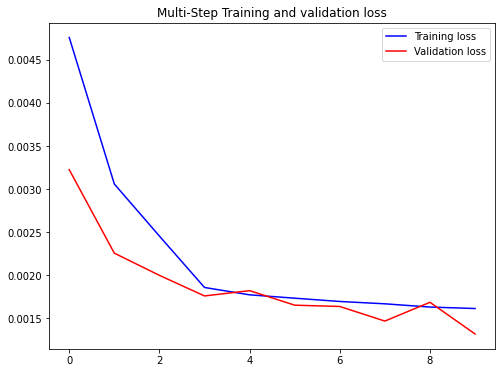

In [510]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    
    
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(history, 'Multi-Step Training and validation loss')

In [511]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

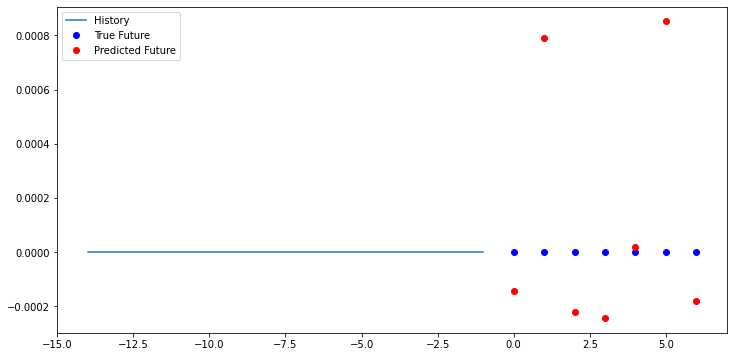

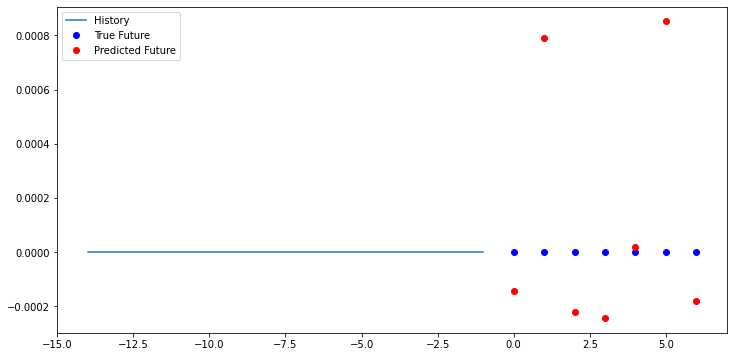

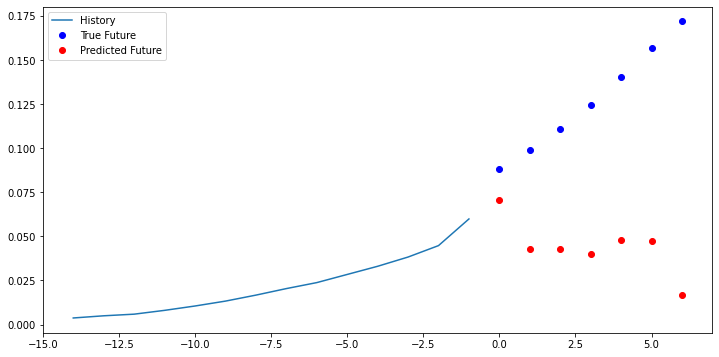

In [512]:
for x, y in test_data_multi.shuffle(1000).take(3):
    multi_step_plot(x[0], y[0], model.predict(x)[0])